In [1]:
# !pip install scikit-learn pandas matplotlib seaborn torch --quiet

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import load_wine, load_breast_cancer, load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

import nll_to_po.training.loss as L
import nll_to_po.training.reward as R
import nll_to_po.models.dn_policy as Policy
from nll_to_po.training.utils import train_single_policy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

<Figure size 640x480 with 0 Axes>

In [2]:
def load_uci(
    dataset="wine", test_size=0.2, val_size=0.2, batch_size=256, standardize=True
):
    if dataset == "wine":
        data = load_wine()
    if dataset == "wine":
        data = load_wine()
    elif dataset == "iris":
        data = load_iris()
    elif dataset == "breast_cancer":
        data = load_breast_cancer()
    elif dataset == "load_digits":
        data = load_digits()
    else:
        raise ValueError(f"Unknown dataset: {dataset}")
    X, y = data.data, data.target
    if standardize:
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)

    # train / (val+test)
    X_tr, X_tt, y_tr, y_tt = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=0
    )
    # split val from train
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_tr, y_tr, test_size=val_size, stratify=y_tr, random_state=0
    )
    # conversion en tensor type pour le donner au dataloader
    X_tr = torch.tensor(X_tr, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    X_tt = torch.tensor(X_tt, dtype=torch.float32)
    y_tr = torch.tensor(y_tr, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)
    y_tt = torch.tensor(y_tt, dtype=torch.long)

    tr_loader = DataLoader(
        TensorDataset(X_tr, y_tr, y_tr, torch.zeros_like(y_tr)),
        batch_size=batch_size,
        shuffle=True,
    )
    # on ne shuffle pas la val et le test
    val_loader = DataLoader(
        TensorDataset(X_val, y_val, y_val, torch.zeros_like(y_val)),
        batch_size=batch_size,
        shuffle=False,
    )
    tst_loader = DataLoader(
        TensorDataset(X_tt, y_tt, y_tt, torch.zeros_like(y_tt)),
        batch_size=batch_size,
        shuffle=False,
    )

    meta = {"input_dim": X.shape[1], "num_classes": len(np.unique(y))}
    return tr_loader, val_loader, tst_loader, meta


train_loader, val_loader, test_loader, meta = load_uci("wine", batch_size=128)

Set up $\widehat{Y}$ c'est le one hot encoding des labels Y et je travaille avec les one hot encoding

In [3]:
@torch.no_grad()
def estimate_trace_sigma_onehot(train_loader, num_classes: int) -> float:
    ys = []
    for _, yb, _, _ in train_loader:
        ys.append(yb)
    y = torch.cat(ys, dim=0)  # (N,)
    Y = F.one_hot(y, num_classes=num_classes).float()  # (N,C)
    Yc = Y - Y.mean(dim=0, keepdim=True)  # (N,C)
    Sigma = (Yc.T @ Yc) / max(Y.shape[0] - 1, 1)  # (C,C)
    return float(torch.trace(Sigma))


def beta_star_from_data(train_loader, entropy_weight: float, num_classes: int) -> float:
    tr = estimate_trace_sigma_onehot(train_loader, num_classes=num_classes)
    return float(entropy_weight * num_classes / (2.0 * max(tr, 1e-12)))

In [ ]:
@torch.no_grad
def evaluate_accuracy_multi_regression(
    policy: nn.Module, data_loader: DataLoader
) -> float:
    policy.eval()
    correct, total = 0, 0
    for xb, yb, _, _ in data_loader:
        # yb est un vecteur [num_samples] a valeur dans les labes [0;1,...,C-1]
        _, prob_predit = policy(xb)
        # one_hot_pred = prob_predit.argmax(dim=-1)
        # print(f'prob shape {prob_predit.shape}')
        # print(f'one hot true shape {yb.shape}')
        y_prob = prob_predit.argmax(dim=-1)
        correct += (y_prob == yb).sum().item()
        total += yb.numel()
    if total == 1:
        return "One element in the dataloader"
    else:
        return correct / max(total, 1)

In [10]:
def run_one_dataset(
    dataset_name: str,
    n_updates: int = 10,
    n_experiments: int = 5,
    batch_size: int = 128,
    learning_rate: float = 1e-4,
    entropy_weight: float = 1e-3,
):
    train_loader, val_loader, test_loader, meta = load_uci(
        dataset=dataset_name, batch_size=batch_size, standardize=True
    )
    C = meta["num_classes"]
    D_in = meta["input_dim"]

    beta_star = beta_star_from_data(
        train_loader, entropy_weight=entropy_weight, num_classes=C
    )
    # beta_list = [1, beta_star]
    beta_list = [2 * beta_star, beta_star]

    curves = []
    tests = []

    for rep in range(n_experiments):
        # policy = MLPClassifier(D_in, C)
        policy = Policy.MulticlassLogisticRegression(D_in, C)
        loss_fn = L.NLL_Classification()

        trained_policy, train_metrics, val_metrics, _, _ = train_single_policy(
            policy=policy,
            train_dataloader=train_loader,
            val_dataloader=val_loader,
            loss_function=loss_fn,
            n_updates=n_updates,
            learning_rate=learning_rate,
            wandb_run=None,
            tensorboard_writer=None,
            logger=None,
        )

        df_tr = (
            pd.DataFrame(train_metrics).reset_index().rename(columns={"index": "epoch"})
        )
        df_tr["split"] = "train"
        df_tr["method"] = "NLL"
        df_tr["beta"] = np.nan
        df_tr["rep"] = rep
        df_val = (
            pd.DataFrame(val_metrics).reset_index().rename(columns={"index": "epoch"})
        )
        df_val["split"] = "val"
        df_val["method"] = "NLL"
        df_val["beta"] = np.nan
        df_val["rep"] = rep
        curves += [df_tr, df_val]

        # test_acc = evaluate_accuracy(policy, test_loader)
        test_acc = evaluate_accuracy_multi_regression(trained_policy, test_loader)
        tests.append(
            {
                "dataset": dataset_name,
                "method": "NLL",
                "beta": np.nan,
                "rep": rep,
                "test_accuracy": test_acc,
            }
        )

    for beta in beta_list:
        U = torch.eye(C) * float(beta)
        reward = R.OneHotMahalanobis(U, num_classes=C)  # reward

        for rep in range(n_experiments):
            policy = Policy.MulticlassLogisticRegression(D_in, C)
            loss_fn = L.PO_Entropy_Classification(
                reward_fn=reward,
                n_generations=50,
                use_rsample=False,
                reward_transform="normalize",
                entropy_weight=entropy_weight,
            )

            beta_trained_policy, train_metrics, val_metrics, _, _ = train_single_policy(
                policy=policy,
                train_dataloader=train_loader,
                val_dataloader=val_loader,
                loss_function=loss_fn,
                n_updates=n_updates,
                learning_rate=learning_rate,
                wandb_run=None,
                tensorboard_writer=None,
                logger=None,
            )

            df_tr = (
                pd.DataFrame(train_metrics)
                .reset_index()
                .rename(columns={"index": "epoch"})
            )
            df_tr["split"] = "train"
            df_tr["method"] = "PO_Entropy"
            df_tr["beta"] = beta
            df_tr["rep"] = rep
            df_val = (
                pd.DataFrame(val_metrics)
                .reset_index()
                .rename(columns={"index": "epoch"})
            )
            df_val["split"] = "val"
            df_val["method"] = "PO_Entropy"
            df_val["beta"] = beta
            df_val["rep"] = rep
            curves += [df_tr, df_val]

            # test_acc = evaluate_accuracy(policy, test_loader)
            # Comment etre sur que le modele policy est bien celui last epoch ??
            test_acc = evaluate_accuracy_multi_regression(
                beta_trained_policy, test_loader
            )
            tests.append(
                {
                    "dataset": dataset_name,
                    "method": "PO_Entropy",
                    "beta": beta,
                    "rep": rep,
                    "test_accuracy": test_acc,
                }
            )

    curves_df = pd.concat(curves, ignore_index=True)
    tests_df = pd.DataFrame(tests)
    curves_df["is_beta_star"] = curves_df["beta"].apply(
        lambda b: isinstance(b, float) and abs(b - beta_star) < 1e-12
    )
    tests_df["is_beta_star"] = tests_df["beta"].apply(
        lambda b: isinstance(b, float) and abs(b - beta_star) < 1e-12
    )
    return curves_df, tests_df, beta_star

In [11]:
def plot_curves_for_dataset(
    curves_df: pd.DataFrame, dataset_name: str, beta_star: float
):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))

    # helpers
    def make_label(row):
        if row["method"] == "NLL":
            return "NLL"
        if pd.isna(row["beta"]):
            return "PO (β=NA)"
        if abs(row["beta"] - beta_star) < 1e-12:
            return "PO (β*)"
        return f"PO (β={row['beta']:.3g})"

    curves_df = curves_df.copy()
    curves_df["label"] = curves_df.apply(make_label, axis=1)

    # colors: NLL blue, β* black, others red
    palette_map = {}
    for lab in curves_df["label"].unique():
        if lab == "NLL":
            palette_map[lab] = "#1f77b4"
        elif lab == "PO (β*)":
            palette_map[lab] = "black"
        else:
            palette_map[lab] = "red"

    # TRAIN
    sub = curves_df[curves_df["split"] == "train"]
    sns.lineplot(
        data=sub,
        x="epoch",
        y="accuracy",
        hue="label",
        errorbar=("ci", 95),
        ax=ax[0],
        palette=palette_map,
        legend=False,
    )
    ax[0].set_title(f"{dataset_name}: Train accuracy vs epoch")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("accuracy")

    # VAL
    sub = curves_df[curves_df["split"] == "val"]
    sns.lineplot(
        data=sub,
        x="epoch",
        y="accuracy",
        hue="label",
        errorbar=("ci", 95),
        ax=ax[1],
        palette=palette_map,
        legend=True,
    )
    ax[1].set_title(f"{dataset_name}: Val accuracy vs epoch")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")
    ax[1].legend(title="method", frameon=False, loc="lower right")

    plt.tight_layout()
    plt.show()

In [12]:
def show_test_table(tests_df: pd.DataFrame, dataset_name: str):
    keep = (tests_df["method"] == "PO_Entropy") | (tests_df["method"] == "NLL")
    df = tests_df[keep].copy()

    grouped = (
        df.groupby(["dataset", "method", "is_beta_star"], dropna=False)["test_accuracy"]
        .agg(["mean", "std", "count"])
        .reset_index()
    )

    def beta_label(row):
        if row["method"] == "NLL":
            return "—"
        return "β*" if row["is_beta_star"] else "β=1"

    grouped["beta_label"] = grouped.apply(beta_label, axis=1)
    grouped = grouped[["dataset", "method", "beta_label", "mean", "std", "count"]]
    grouped = grouped[grouped["dataset"] == dataset_name]

    print(f"Test accuracy summary — {dataset_name}")
    display(grouped.style.format({"mean": "{:.4f}", "std": "{:.4f}"}))

Training epochs:  11%|█         | 33/300 [00:00<00:00, 272.10it/s]


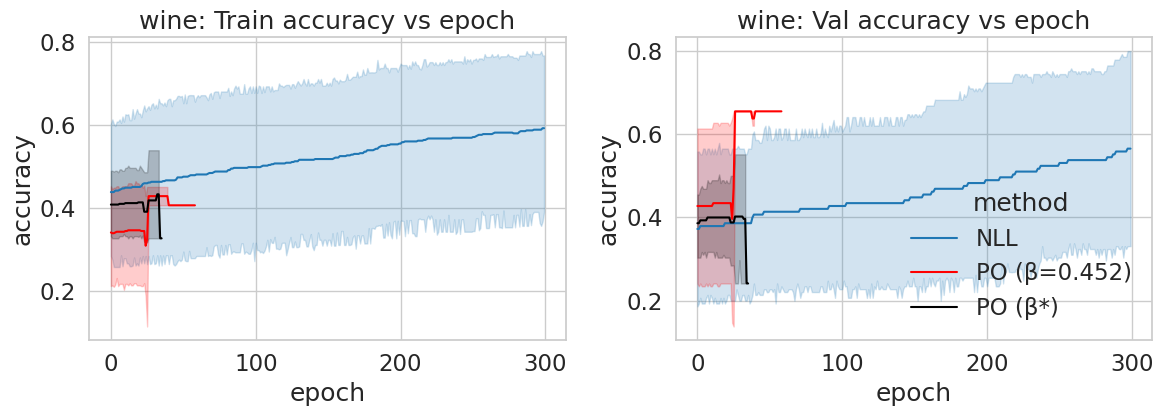

Test accuracy summary — wine


,dataset,method,beta_label,mean,std,count
0,wine,NLL,—,0.5444,0.1980,5
1,wine,PO_Entropy,β=1,0.3667,0.2200,5
2,wine,PO_Entropy,β*,0.4278,0.0576,5


Training epochs:  21%|██        | 62/300 [00:00<00:00, 248.59it/s]


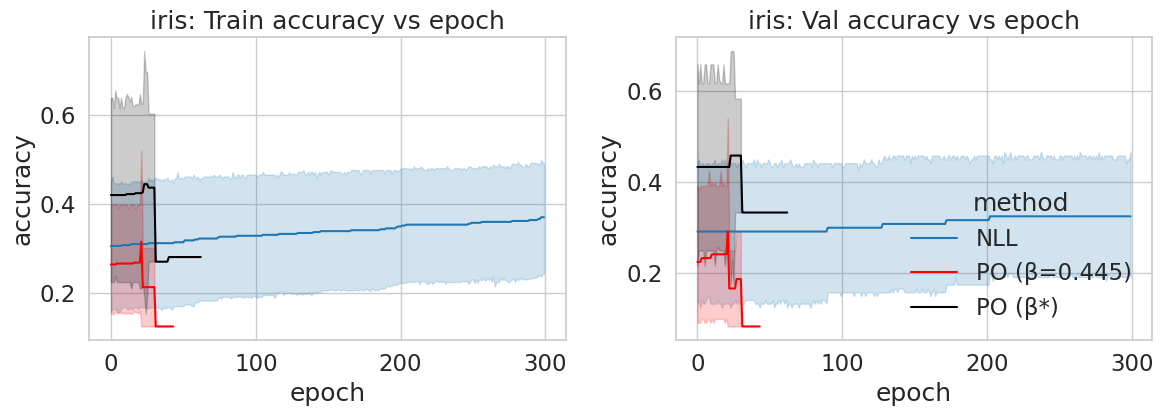

Test accuracy summary — iris


,dataset,method,beta_label,mean,std,count
0,iris,NLL,—,0.3933,0.1535,5
1,iris,PO_Entropy,β=1,0.2800,0.1643,5
2,iris,PO_Entropy,β*,0.4133,0.1880,5


Training epochs:  15%|█▍        | 44/300 [00:00<00:02, 97.94it/s] 


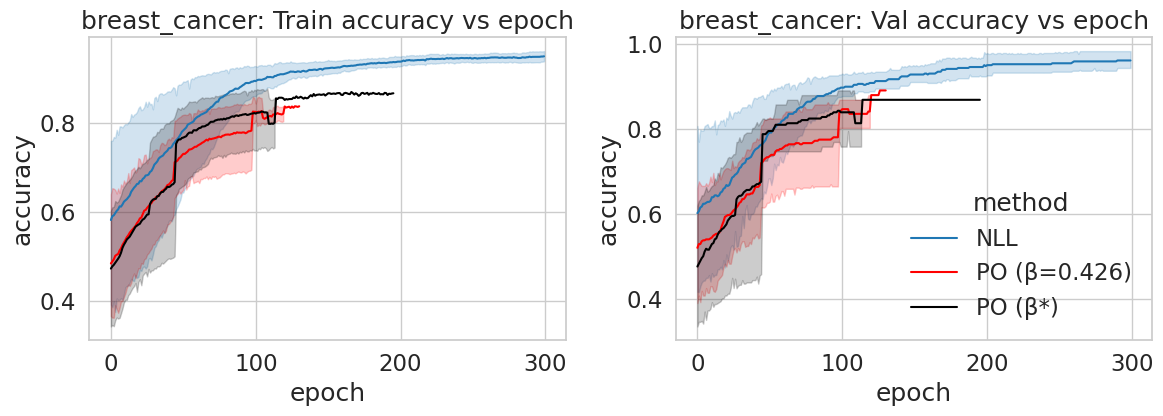

Test accuracy summary — breast_cancer


,dataset,method,beta_label,mean,std,count
0,breast_cancer,NLL,—,0.9439,0.0202,5
1,breast_cancer,PO_Entropy,β=1,0.7123,0.1505,5
2,breast_cancer,PO_Entropy,β*,0.6579,0.2082,5


Training epochs:   7%|▋         | 21/300 [00:00<00:12, 21.83it/s]


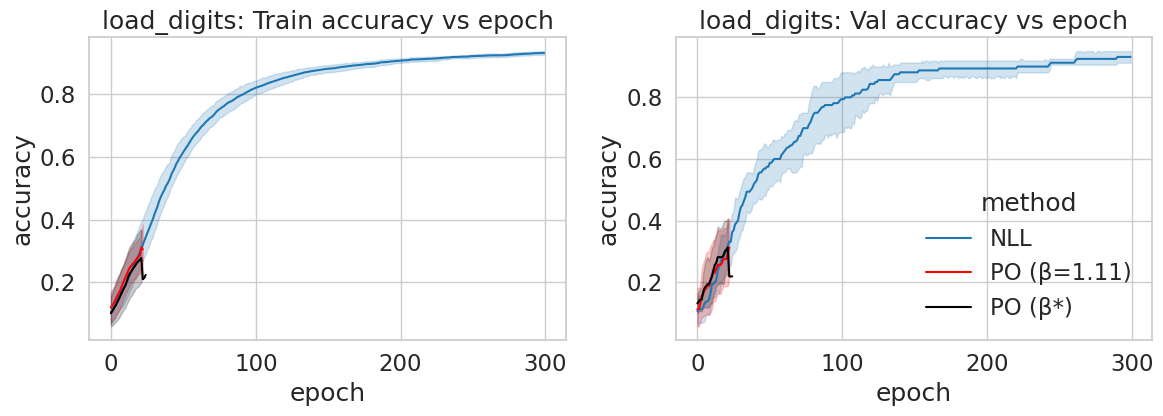

Test accuracy summary — load_digits


,dataset,method,beta_label,mean,std,count
0,load_digits,NLL,—,0.9050,0.0053,5
1,load_digits,PO_Entropy,β=1,0.2783,0.0486,5
2,load_digits,PO_Entropy,β*,0.2728,0.1118,5


In [13]:
datasets = ["wine", "iris", "breast_cancer", "load_digits"]

all_curves = []
all_tests = []

for ds in datasets:
    curves_df, tests_df, bstar = run_one_dataset(
        dataset_name=ds,
        n_updates=300,
        n_experiments=5,
        batch_size=128,
        learning_rate=1e-4,
        entropy_weight=1e-1,
    )
    plot_curves_for_dataset(curves_df, ds, bstar)
    show_test_table(tests_df, ds)

    curves_df["dataset"] = ds
    tests_df["dataset"] = ds
    all_curves.append(curves_df)
    all_tests.append(tests_df)

df_curves_all = pd.concat(all_curves, ignore_index=True)
df_tests_all = pd.concat(all_tests, ignore_index=True)